In [58]:
import io
import os
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)
from helper import Gpt2ClassificationCollator, MovieReviewsDataset

seed = 1520
set_seed(seed)

/home/stu00608/miniconda3/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [89]:
epochs = 4

batch_size = 32

# Text sequence length, will pad or truncate to the same size.
max_length = 60

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "gpt2"

# 2 labels: negative and positive.
label_ids = {"neg": 0, "pos": 1}
ids_label = {0: "neg", 1: "pos"}

n_labels = len(label_ids)

/home/stu00608/miniconda3/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Get model configuration.
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name, num_labels=n_labels)

# Get model tokenizer.
model_tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name)

# Left padding
model_tokenizer.padding_side = "left"
# Make pad token same as EOS
model_tokenizer.pad_token = model_tokenizer.eos_token

# Load the model

model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name, config=model_config)
model.resize_token_embeddings(len(model_tokenizer))
# Make pad token same as EOS
model.config.pad_token_id = model.config.eos_token_id
model.to(device)

/home/stu00608/miniconda3/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid

In [5]:
gpt2_classification_collator = Gpt2ClassificationCollator(
    use_tokenizer=model_tokenizer,
    labels_encoder=label_ids,
    max_sequence_len=max_length
)
print("Created a collator.")

train_dataset = MovieReviewsDataset(
    path="./aclImdb/train/",
    use_tokenizer=model_tokenizer
)
print(f"Created train dataset with {len(train_dataset)} samples.")

valid_dataset = MovieReviewsDataset(
    path="./aclImdb/test/",
    use_tokenizer=model_tokenizer
)
print(f"Created validation dataset with {len(valid_dataset)} samples.")

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=gpt2_classification_collator
)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=gpt2_classification_collator
)
print('Created `valid_dataloader` with %d batches!'%len(train_dataloader))

/home/stu00608/miniconda3/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Created a collator.


neg files: 100%|██████████| 12500/12500 [00:02<00:00, 5235.67it/s]


Created train dataset with 25000 samples.


neg files: 100%|██████████| 12500/12500 [00:58<00:00, 213.48it/s]

Created validation dataset with 25000 samples.
Created `train_dataloader` with 782 batches!
Created `valid_dataloader` with 782 batches!


In [93]:
def train(epoch, dataloader, optimizer, scheduler, device):
    # Take global model.
    global model

    # Tracking variables.
    predictions_labels = []
    true_labels = []
    # Total loss for this epoch.
    total_loss = 0

    # Put the model into training mode.
    model.train()

    with tqdm(dataloader, total=len(dataloader), unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch}/{epochs}")
        for batch in tepoch:

            true_labels += batch["labels"].numpy().flatten().tolist()

            # Move batch data to device
            batch = {x: y.type(torch.long).to(device) for x, y in batch.items()}

            model.zero_grad()
        
            outputs = model(**batch)
            loss, logits = outputs[:2]

            total_loss += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Optimizer and Scheduler regulation.
            optimizer.step()
            scheduler.step()

            logits = logits.detach().cpu().numpy()

            predictions_labels += logits.argmax(axis=-1).flatten().tolist()

            tepoch.set_postfix(loss=loss.item())
    
    avg_epoch_loss = total_loss / len(dataloader)

    return true_labels, predictions_labels, avg_epoch_loss

def validation(dataloader, device):
    global model

    # Tracking variables
    predictions_labels = []
    true_labels = []
    #total loss for this epoch.
    total_loss = 0

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluatdion.
    model.eval()

    with tqdm(dataloader, total=len(dataloader), unit="batch") as tepoch:
        for batch in tepoch:

            true_labels += batch["labels"].numpy().flatten().tolist()

            # Move batch data to device
            batch = {x: y.type(torch.long).to(device) for x, y in batch.items()}

            with torch.no_grad():
                outputs = model(**batch)
                loss, logits = outputs[:2]
                total_loss += loss.item()
                logits = logits.detach().cpu().numpy()

                predict_content = logits.argmax(axis=-1).flatten().tolist()

                predictions_labels += predict_content

            tepoch.set_postfix(loss=loss.item())
    
    avg_epoch_loss = total_loss / len(dataloader)

    return true_labels, predictions_labels, avg_epoch_loss
    
def inference(text):
    global model

    token = model_tokenizer(
        text=[text], 
        return_tensors="pt",                    
        padding=True, 
        truncation=True,  
        max_length=max_length
    )
    token = token.to(device)

    model.eval()

    with torch.no_grad():
        outputs = model(input_ids=token["input_ids"], attention_mask=token["attention_mask"])
        logits = outputs[0].detach().cpu().numpy()
        logits = logits.argmax(axis=-1)
    
    return ids_label[logits[0]]

/home/stu00608/miniconda3/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/stu00608/miniconda3/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/stu00608/miniconda3/envs/ml/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 782/782 [00:51<00:00, 15.05batch/s, loss=0.0503]




Epoch 0/4
	train_loss : 0.3551
	valid_loss : 0.3933
	train_acc : 0.8376
	valid_acc : 0.8298
	


100%|██████████| 782/782 [00:49<00:00, 15.79batch/s, loss=0.0502]




Epoch 1/4
	train_loss : 0.2929
	valid_loss : 0.3862
	train_acc : 0.8732
	valid_acc : 0.8284
	


100%|██████████| 782/782 [00:51<00:00, 15.32batch/s, loss=0.114] 




Epoch 2/4
	train_loss : 0.2375
	valid_loss : 0.4132
	train_acc : 0.9026
	valid_acc : 0.8306
	


100%|██████████| 782/782 [00:51<00:00, 15.17batch/s, loss=0.511] 
/home/stu00608/miniconda3/envs/ml/lib/python3.8/site-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',




Epoch 3/4
	train_loss : 0.1983
	valid_loss : 0.4509
	train_acc : 0.9190
	valid_acc : 0.8306
	


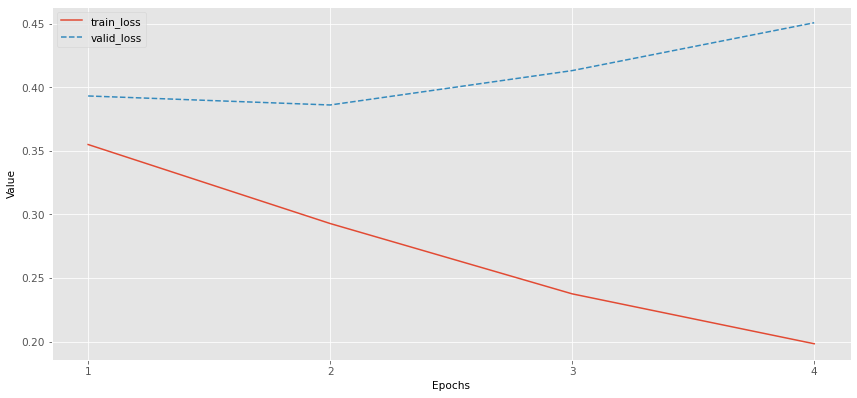

/home/stu00608/miniconda3/envs/ml/lib/python3.8/site-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


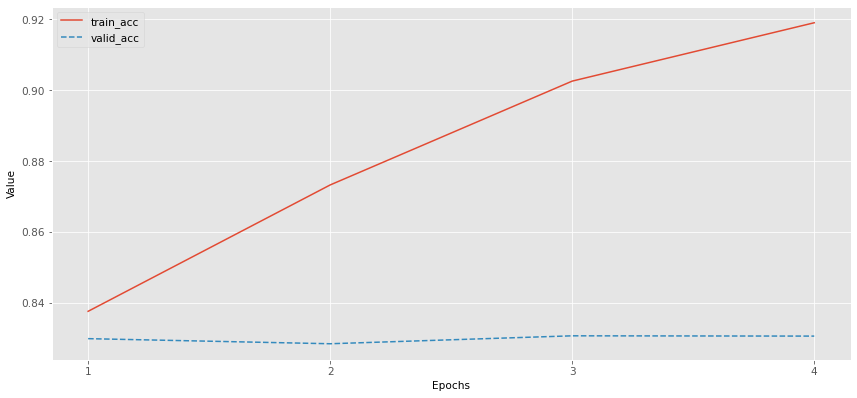

In [19]:
total_steps = len(train_dataloader)*epochs

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(
    model.parameters(),
    lr = 2e-5, # default is 5e-5, our notebook had 2e-5
    eps = 1e-8 # default is 1e-8.
)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Metrics
all_loss = {
    "train_loss": [],
    "valid_loss": []
}
all_acc = {
    "train_acc": [],
    "valid_acc": []
}

for epoch in range(1, epochs+1):

    # Train step
    train_labels, train_predict, train_loss = train(
        epoch=epoch, 
        dataloader=train_dataloader,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device
    )
    train_acc = accuracy_score(train_labels, train_predict)

    # Validation step
    valid_labels, valid_predict, valid_loss = validation(
        dataloader=valid_dataloader,
        device=device
    )
    valid_acc = accuracy_score(valid_labels, valid_predict)

    print(f"\n\nEpoch {epoch}/{epochs}\n\ttrain_loss : {train_loss:.4f}\n\tvalid_loss : {valid_loss:.4f}\n\ttrain_acc : {train_acc:.4f}\n\tvalid_acc : {valid_acc:.4f}\n\t")

    all_loss["train_loss"].append(train_loss)
    all_loss["valid_loss"].append(valid_loss)
    all_acc["train_acc"].append(train_acc)
    all_acc["valid_acc"].append(valid_acc)

plot_dict(all_loss, use_xlabel="Epochs", use_ylabel="Value", use_linestyles=['-', '--'])
plot_dict(all_acc, use_xlabel="Epochs", use_ylabel="Value", use_linestyles=['-', '--'])

In [73]:
text = "It's a worst movie I ever seen."
tag = inference(text)
print(tag)

/home/stu00608/miniconda3/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
